> # Preprocessing

In [1]:
import keras
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, AveragePooling2D
from keras.models import Model, load_model, Sequential
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import numpy as np
import os
import random
from PIL import Image
from pathlib import Path
import seaborn as sns
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
import os
from pathlib import Path
path = Path('/kaggle/input/food41/images')
food_names = os.listdir(path)

Number of classes: 101


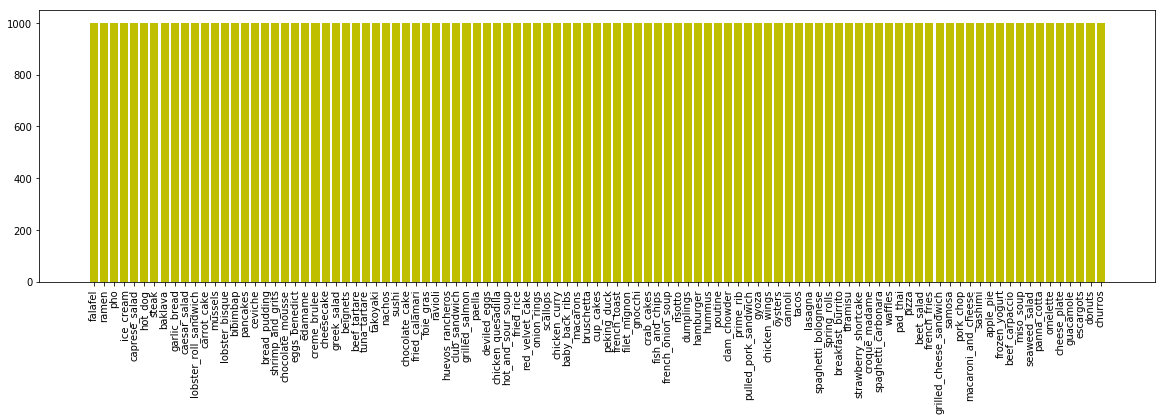

In [3]:
files = os.listdir(path)
num_classes = len(files)
print ('Number of classes:', num_classes)

dist = dict()
# class distribution
for f in files:
    dist[f] = len(os.listdir(path/f))
plt.figure(figsize=(20, 5))
plt.bar(list(dist.keys()), dist.values(), color='y')
plt.xticks(rotation=90)
plt.show() # Plotting class distribution

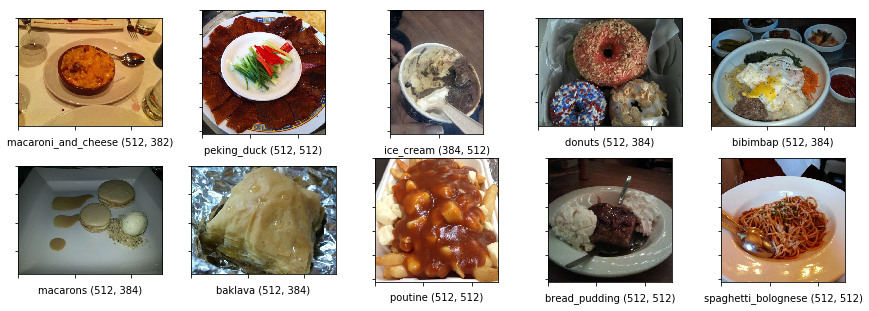

In [4]:
import matplotlib.pyplot as plt
import random
from PIL import Image
def show_img(rows, cols, figsize=None):
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    for i in range(rows):
        for j in range(cols):
            random_folder = random.choice(files)
            random_file = random.choice(os.listdir(path/random_folder))
            im = Image.open(path/random_folder/random_file)
            ax[i, j].imshow(im)
            ax[i, j].set_xlabel(str(random_folder) + " " + str(im.size))
            ax[i, j].set_yticklabels([])
            ax[i, j].set_xticklabels([])
            ax[i, j].grid(False)

show_img(2, 5, (15, 5))

In [5]:
# Generate batches of image data with real-time data augmentation using ImageDataGenerator

batch_size = 64
datagen = ImageDataGenerator(rescale=1./255,
                             shear_range=0.3,
                             zoom_range=0.2,
                             preprocessing_function=preprocess_input,
                             validation_split=0.2,
                             horizontal_flip=True)

shape = (324, 324)
train_generator = datagen.flow_from_directory(path,
                                              target_size=shape,
                                              batch_size=batch_size,
                                              subset='training',
                                              class_mode='categorical')

val_generator = datagen.flow_from_directory(path,
                                            target_size=shape,
                                            batch_size=batch_size,
                                            subset='validation',
                                            class_mode='categorical')

Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


In [6]:
!pip install efficientnet

In [7]:
# !pip install wandb

In [8]:
# import wandb
# from wandb.keras import WandbCallback

# Wandb used to record and visualize every detail of model training.
# Hyperparameters

lr = 0.01 
beta_1 = 0.9
beta_2 = 0.999
decay = 1e-8
hidden_layers = 256
dropout = 0.5



#name = "efficientnet"
# wandb.init(project="food101", magic=True, config = defaults, name = name)
# config = wandb.config

In [9]:
import efficientnet.keras as eff

class my_Models:
    def eff_net(hidden_layers, dropout, trainable= False):
        base_model = eff.EfficientNetB3(weights='imagenet', include_top=False, pooling='avg')
        for layer in base_model.layers:
            layer.trainable = trainable
        x = base_model.output
        x = Dense(hidden_layers, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout)(x)
        predictions = Dense(num_classes, activation='softmax')(x)
        model = Model(inputs=base_model.input, outputs=predictions)
        return model 
    
    def xception(hidden_layers, dropout, trainable= False):
        base_model = Xception(weights='imagenet', include_top=False, pooling='avg')
        for layer in base_model.layers:
            layer.trainable = False
        x = base_model.output
        x = Dense(hidden_layers, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout)(x)
        predictions = Dense(num_classes, activation='softmax')(x)
        model = Model(inputs=base_model.input, outputs=predictions)
    
        for layer in model.layers[:122]:
            layer.trainable = False
        for layer in model.layers[122:]:
            layer.trainable = trainable       
        return model 

# Training the EfficientNet model

In [10]:
from keras.metrics import top_k_categorical_accuracy

def top_2(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)
def top_3(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)
def top_5(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

#adam = Adam(lr=config.lr, beta_1=config.beta_1, beta_2=config.beta_2, epsilon=None, decay=config.decay, amsgrad=True)
nadam = keras.optimizers.Nadam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2)
weights_path = '../working/eff_weights.hdf5'
mc = ModelCheckpoint(filepath=weights_path, monitor='val_acc', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_acc', patience=3, verbose=1)
hidden_layers = 256
dropout = 0.5
model = my_Models.xception(hidden_layers, dropout, trainable = True)
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['acc', top_3, top_5])

83689472/83683744 [==============================] - 1s 0us/step


In [11]:
# Training the model
history = model.fit_generator(train_generator, epochs=7,
                              steps_per_epoch=train_generator.samples // batch_size,
                              validation_data=val_generator,
                              validation_steps=val_generator.samples // batch_size,
                              callbacks=[mc, es])

Epoch 1/7
1262/1262 [==============================] - 3105s 2s/step - loss: 2.3462 - acc: 0.4203 - top_3: 0.6151 - top_5: 0.6989 - val_loss: 2.5064 - val_acc: 0.3882 - val_top_3: 0.5726 - val_top_5: 0.6590

Epoch 00001: val_acc improved from -inf to 0.38819, saving model to ../working/eff_weights.hdf5
Epoch 2/7
1262/1262 [==============================] - 2902s 2s/step - loss: 1.6746 - acc: 0.5752 - top_3: 0.7578 - top_5: 0.8242 - val_loss: 2.3122 - val_acc: 0.4485 - val_top_3: 0.6395 - val_top_5: 0.7175

Epoch 00002: val_acc improved from 0.38819 to 0.44845, saving model to ../working/eff_weights.hdf5
Epoch 3/7
1262/1262 [==============================] - 2906s 2s/step - loss: 1.4459 - acc: 0.6291 - top_3: 0.8015 - top_5: 0.8572 - val_loss: 2.4579 - val_acc: 0.4280 - val_top_3: 0.6178 - val_top_5: 0.6984

Epoch 00003: val_acc did not improve from 0.44845
Epoch 4/7
1262/1262 [==============================] - 2903s 2s/step - loss: 1.3042 - acc: 0.6621 - top_3: 0.8262 - top_5: 0.8774 -

EfficientNet


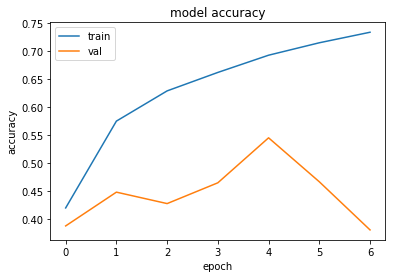

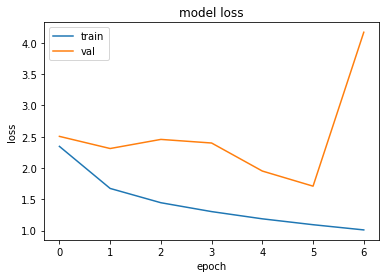

In [12]:
print("EfficientNet")
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


# Model Tuning

In [13]:
import keras

model = my_Models.xception(hidden_layers, dropout, trainable = True)
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['acc', top_3, top_5])

model.load_weights(weights_path)
weights_path = '../working/eff_weights_tuned.hdf5'

mc = ModelCheckpoint(filepath=weights_path, monitor='val_acc', verbose=1, save_best_only=True)
history = model.fit_generator(train_generator, epochs=5,
                              steps_per_epoch=train_generator.samples // batch_size,
                              validation_data=val_generator,
                              validation_steps=val_generator.samples // batch_size,
                              callbacks=[mc, es])
model.save(os.path.join(wandb.run.dir, "eff_weights_end.h5"))

Epoch 1/5
1262/1262 [==============================] - 2909s 2s/step - loss: 1.5138 - acc: 0.6213 - top_3: 0.7877 - top_5: 0.8442 - val_loss: 2.0561 - val_acc: 0.5279 - val_top_3: 0.7063 - val_top_5: 0.7787

Epoch 00001: val_acc improved from -inf to 0.52793, saving model to ../working/eff_weights_tuned.hdf5
Epoch 2/5
1262/1262 [==============================] - 2881s 2s/step - loss: 1.1059 - acc: 0.7133 - top_3: 0.8595 - top_5: 0.9031 - val_loss: 2.5095 - val_acc: 0.5132 - val_top_3: 0.6891 - val_top_5: 0.7575

Epoch 00002: val_acc did not improve from 0.52793
Epoch 3/5
1262/1262 [==============================] - 2851s 2s/step - loss: 0.9730 - acc: 0.7445 - top_3: 0.8814 - top_5: 0.9201 - val_loss: 2.9400 - val_acc: 0.4841 - val_top_3: 0.6619 - val_top_5: 0.7385

Epoch 00003: val_acc did not improve from 0.52793
Epoch 4/5
1262/1262 [==============================] - 2912s 2s/step - loss: 0.8846 - acc: 0.7639 - top_3: 0.8942 - top_5: 0.9302 - val_loss: 2.3876 - val_acc: 0.5102 - val_t

NameError: name 'wandb' is not defined

EfficientNet with Tuning: 


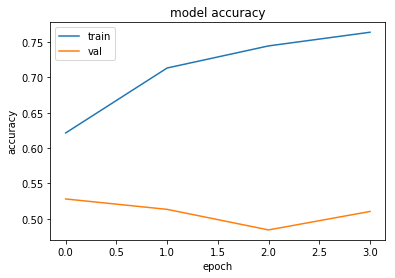

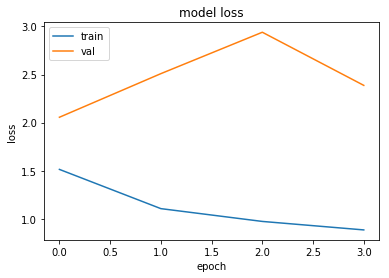

In [14]:
print("EfficientNet with Tuning: ")
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

(64, 101) (64, 101) (64,)


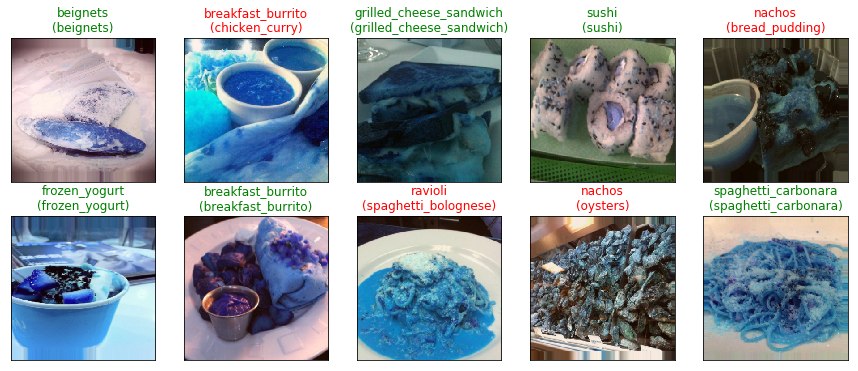

In [15]:
from keras.preprocessing.image import array_to_img
img, lbl = val_generator.next()

y_proba = model.predict_on_batch(img)
y_classes = y_proba.argmax(axis=-1)
print (y_proba.shape, lbl.shape, y_classes.shape)


images, predict = img, lbl
true_classes = np.argmax(lbl, axis=1)
pred_classes = y_classes
label_map = train_generator.class_indices

true_lbl = [dict((v,k) for k,v in label_map.items()).get(true_classes[i]) for i in range(len(true_classes))]
pred_lbl = [dict((v,k) for k,v in label_map.items()).get(pred_classes[i]) for i in range(len(pred_classes))]

fig = plt.figure(figsize=(15, 6))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    ax.imshow(array_to_img(images[idx]))
    ax.set_title("{}\n({})".format(str(pred_lbl[idx]), str(true_lbl[idx])),
                 color=("green" if true_lbl[idx]==pred_lbl[idx] else "red"))
